In [2]:
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import seaborn as sns
import numpy as np
from scipy.stats import norm
import timeit

## Constraints:
- Demand should be satisfied during lead time: demand ≤ 𝜎 * lead time. This implies the safety stock should be enough to cover the demand variability during lead time.
- Lead time should be within the given lead time for each product: LT ≤ lead time
- Inventory should be sufficient to meet the demand: starting stock + ∑(𝑄) − ∑(demand) ≥ 0
- Order Quantity Constraints: minimum order quantity (Q ≥ 20% * average demand)

To optimize the safety stock calculation and obtain optimal solutions, the following improvements were performed:

- Dynamic Z-score Calculation: Instead of using a fixed Z-score like 1.65, the program dynamically calculates the Z-score based on the desired service level or confidence level. This allows for flexibility in setting the appropriate level of risk tolerance.

- Refined Demand Distribution: Rather than relying on a simple mixture of two normal distributions, used historical demand data to fit a more accurate demand distribution, such as a normal distribution or another appropriate probability distribution. This ensures that the demand variability is adequately captured.

- Simulation-based Optimization: simulation-based optimization algorithms to iteratively adjust parameters (e.g., reorder quantity, safety stock level) to maximize expected profit while meeting service level constraints and minimizing costs.

## Periodic review

**safety_stock = z * std_dev_daily_sales * np.sqrt(lead_time)**

## OUP: Order upto level
The order-up-to level is the inventory level up to which a business will replenish its stock during each review period. It ensures that the company maintains enough inventory to meet expected demand during the lead time plus a buffer for variability in demand and lead time.

### Order-Up-To Level Calculation
To calculate the order-up-to level, the following formula is typically used:

OUP = Safety Stock + Expected Demand During Lead Time

Where:

- Safety Stock: A buffer stock to protect against uncertainties in demand and lead time.
- Expected Demand During Lead Time: The average demand expected to occur during the lead time.

### Safety Stock Calculation
Safety stock can be calculated using the formula:

Safety Stock = z * σd * LT

Where:

- z is the z-score corresponding to the desired service level (e.g., 1.65 for a 95% service level).
- σd is the standard deviation of daily demand.
- LT is the lead time in days.

### Expected Demand During Lead Time
The expected demand during lead time is calculated as:

Expected Demand During Lead Time = Average Daily Demand * Lead Time

### OUP in the Simulation
safety_stock = calculate_safety_stock(z_score, std_dev_daily_sales, lead_time)

### Reorder Point Calculation (Order-Up-To Level):

- q = max(0, safety_stock + demand_lead - inventory)
- q = max(q, int(0.2 * mean)) (Minimum order quantity)

The reorder point ensures that the inventory is replenished up to the calculated level, accounting for both the expected demand and the buffer stock.

The OUP is the target inventory level up to which stock is replenished during each review period. It ensures that the business can meet demand during the lead time with a high service level by maintaining a sufficient buffer stock (safety stock) and accounting for the average expected demand during the lead time.

In [64]:
start = timeit.default_timer()

def calculate_safety_stock(z, std_dev_daily_sales, lead_time):
    safety_stock = z * std_dev_daily_sales * np.sqrt(lead_time)
    return safety_stock

summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Expected Demand (Lead Time)': [705, 3891, 2266, 785]
}

class Product:
    def __init__(self, i):
        self.mean = np.mean([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.sd = np.std([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.mean_demand_lead_time = summary['Mean Demand (Lead Time)'][i - 1]
        self.std_dev_demand_lead_time = summary['Std. Dev. of Demand (Lead Time)'][i - 1]
        self.expected_demand_lead_time = summary['Expected Demand (Lead Time)'][i - 1]

def daily_demand(mean, sd, probability):
    if np.random.uniform(0, 1) > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS_periodic(product, review_period=15, min_order_ratio=0.2, simulations=10000):
    profit_list = []
    lost_orders_list = []
    reorder_quantities = []
    safety_stocks = []

    for _ in range(simulations):
        inventory = product.starting_stock
        mean = product.mean
        sd = product.sd
        lead_time = product.lead_time
        probability = product.probability
        demand_lead = product.expected_demand_lead_time

        high_demand_value = 2 * mean
        weights = [0.8, 0.2]
        means = [mean, high_demand_value]
        sds = [sd, sd]

        daily_sales = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]
        std_dev_daily_sales = np.std(daily_sales)

        safety_stock = calculate_safety_stock(1.65, std_dev_daily_sales, lead_time)
        reorder_point = safety_stock + demand_lead

        min_order_quantity = max(int(min_order_ratio * mean), 1)

        q = 0
        stock_out = 0
        counter = 0
        order_placed = False
        units_sold = []
        orders = []
        inv_level = []

        for day in range(1, 365):
            day_demand = daily_demand(mean, sd, probability)

            if day % review_period == 0 and not order_placed:
                q = max(safety_stock + demand_lead - inventory, min_order_quantity)
                order_placed = True
                reorder_quantities.append(q)
                orders.append(q)

            if order_placed:
                counter += 1

            if counter == lead_time:
                inventory += q
                order_placed = False
                counter = 0

            if inventory - day_demand >= 0:
                units_sold.append(day_demand)
                inventory -= day_demand
            else:
                units_sold.append(inventory)
                stock_out += 1
                inventory = 0

            inv_level.append(inventory)

        avg_safety_stock = safety_stock * 365 / review_period
        safety_stocks.append(avg_safety_stock)

        lost_orders_list.append(stock_out / 365)
        profit_list.append((reorder_point - inventory) * product.unit_cost + (inventory * product.holding_cost * product.size) + (len(reorder_quantities) * product.ordering_cost))

    return {
        'profits': profit_list,
        'mean_profit': np.mean(profit_list),
        'std_dev_profit': np.std(profit_list),
        'lost_order_proportion': np.mean(lost_orders_list),
        'reorder_quantity': np.mean(reorder_quantities),
        'average_safety_stock': np.mean(safety_stocks),
        'units_sold': units_sold,
        'orders': orders,
        'inv_level': inv_level
    }

products = [Product(i) for i in range(1, 5)]
results = {}

def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

for product in products:
    data = MCS_periodic(product=product, min_order_ratio=0.2)
    profit = profit_calculation(data, product)
    results[f'Pr{product.i}'] = {
        'profits': data['profits'],
        'mean_profit': data['mean_profit'],
        'std_dev_profit': data['std_dev_profit'],
        'lost_order_proportion': data['lost_order_proportion'],
        'reorder_quantity': data['reorder_quantity'],
        'average_safety_stock': data['average_safety_stock'],
        'profit': profit
    }

for key, value in results.items():
    print(f"Product {key}:")
    print(f"  Mean Profit: {value['mean_profit']}")
    print(f"  Profit Std Dev: {value['std_dev_profit']}")
    print(f"  Proportion of Lost Orders: {value['lost_order_proportion']}")
    print(f"  Average Reorder Quantity: {value['reorder_quantity']}")
    print(f"  Average Safety Stock: {value['average_safety_stock']}")
    print(f"  Profit: {value['profit']}\n")

stop = timeit.default_timer()
print('Time: ', stop - start)



Product Pr1:
  Mean Profit: 120020615.53735091
  Profit Std Dev: 69282031.92567268
  Proportion of Lost Orders: 0.6864712328767123
  Average Reorder Quantity: 717.8959177855055
  Average Safety Stock: 315.3951837931198
  Profit: 79327.59623562101

Product Pr2:
  Mean Profit: 144041730.4097332
  Profit Std Dev: 83138438.3521563
  Proportion of Lost Orders: 0.9205479452054793
  Average Reorder Quantity: 3904.3442476010073
  Average Safety Stock: 324.7100249578493
  Profit: 281049.4783675834

Product Pr3:
  Mean Profit: 120025706.36203615
  Profit Std Dev: 69282037.28941068
  Proportion of Lost Orders: 0.6437353424657535
  Average Reorder Quantity: 1770.3529025966743
  Average Safety Stock: 479.548786322801
  Profit: 159282.9813422749

Product Pr4:
  Mean Profit: 144042328.8404755
  Profit Std Dev: 83138445.98134872
  Proportion of Lost Orders: 0.1815027397260274
  Average Reorder Quantity: 590.7308830397366
  Average Safety Stock: 369.9725572032401
  Profit: 381553.1026361082

Time:  106

## Plot (Pr1)

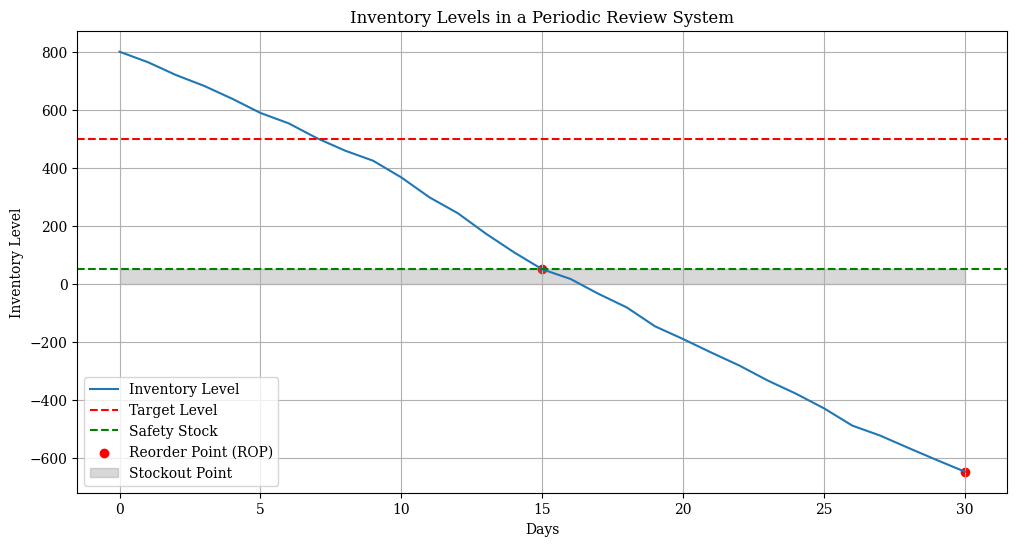

In [48]:
review_period = 15
lead_time = 9
z_score = 1.65
demand_mean = 50
demand_std = 10
initial_inventory = 800

expected_demand_during_lead_time = demand_mean * lead_time
safety_stock = z_score * demand_std * np.sqrt(lead_time)

target_level = expected_demand_during_lead_time + safety_stock

days = 30
inventory_levels = [initial_inventory] + [0] * (days + lead_time)
orders = []
reorder_points = []
safety_stocks = [safety_stock]
stockouts = []

for day in range(1, days + 1):

    daily_demand = np.random.normal(demand_mean, demand_std)
    if daily_demand < 0:
        daily_demand = 0

    inventory_levels[day] = inventory_levels[day - 1] - daily_demand

    if day % review_period == 0:
        # inventory position (current inventory + orders placed but not yet received)
        inventory_position = inventory_levels[day]

        # order quantity required to reach the target level
        order_quantity = target_level - inventory_position
        if order_quantity < 0:
            order_quantity = 0

        orders.append(order_quantity)
        reorder_points.append(inventory_levels[day])

        if day + lead_time <= days:
            inventory_levels[day + lead_time] += order_quantity

    else:
        orders.append(0)
        reorder_points.append(None)


    safety_stocks.append(safety_stock)
    stockouts.append(0)


inventory_levels = inventory_levels[:days + 1]

plt.figure(figsize=(12, 6))
plt.plot(range(days + 1), inventory_levels, label='Inventory Level')
plt.axhline(y=target_level, color='red', linestyle='--', label='Target Level')
plt.axhline(y=safety_stock, color='green', linestyle='--', label='Safety Stock')
plt.scatter(range(1, days + 1), reorder_points, color='red', label='Reorder Point (ROP)')
plt.fill_between(range(days + 1), 0, safety_stock, color='gray', alpha=0.3, label='Stockout Point')
plt.xlabel('Days')
plt.ylabel('Inventory Level')
plt.title('Inventory Levels in a Periodic Review System')
plt.legend()
plt.grid(True)
plt.show()


## continuous review
The logic of the continuous review:
- the safety stock is calculated using the standard deviation of daily sales and the lead time.
- the reorder point is then determined as the sum of safety stock and the expected demand during the lead time.
- the inventory level is checked daily. If the inventory level falls below or equals the reorder point and no order is currently placed, an order is triggered.
- the order quantity (q) is calculated to bring the inventory back up to the safety stock level plus expected demand during the lead time, ensuring a minimum order quantity.
- order is placed, and a counter starts to track the lead time for the order arrival. When the counter reaches the lead time, the ordered quantity is added to the inventory, and the counter is reset.

In [65]:
start = timeit.default_timer()

def calculate_safety_stock(z, std_dev_daily_sales, lead_time):
    safety_stock = z * std_dev_daily_sales * np.sqrt(lead_time)
    return safety_stock

summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Expected Demand (Lead Time)': [705, 3891, 2266, 785]
}

class Product:
    def __init__(self, i):
        self.mean = np.mean([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.sd = np.std([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.mean_demand_lead_time = summary['Mean Demand (Lead Time)'][i - 1]
        self.std_dev_demand_lead_time = summary['Std. Dev. of Demand (Lead Time)'][i - 1]
        self.expected_demand_lead_time = summary['Expected Demand (Lead Time)'][i - 1]

def daily_demand(mean, sd, probability):
    if np.random.uniform(0, 1) > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS_periodic(product, review_period=15, z_score=1.65, min_order_ratio=0.2):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.expected_demand_lead_time

    high_demand_value = 2 * mean
    weights = [0.8, 0.2]
    means = [mean, high_demand_value]
    sds = [sd, sd]

    daily_sales = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]
    std_dev_daily_sales = np.std(daily_sales)

    safety_stock = calculate_safety_stock(z_score, std_dev_daily_sales, lead_time)
    reorder_point = safety_stock + demand_lead

    min_order_quantity = max(int(min_order_ratio * mean), 1)

    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': [], 'reorder_quantities': []}

    total_safety_stock = 0

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if day % review_period == 0 and not order_placed:
            q = max(safety_stock + demand_lead - inventory, min_order_quantity)
            order_placed = True
            data['orders'].append(q)
            data['reorder_quantities'].append(q)

        if order_placed:
            counter += 1

        if counter == lead_time:
            inventory += q
            order_placed = False
            counter = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        else:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)
        total_safety_stock += safety_stock

    average_safety_stock = total_safety_stock / 365

    return data, average_safety_stock


def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

products = [Product(i) for i in range(1, 5)]
results = {}
for product in products:
    profit_list = []
    lost_orders_list = []
    reorder_quantities = []
    safety_stocks = []
    for _ in range(10000):
        data, avg_safety_stock = MCS_periodic(product=product, min_order_ratio=0.2)
        profit = profit_calculation(data, product)
        profit_list.append(profit)
        lost_orders_list.append(len(data['units_lost']) / 365)
        reorder_quantities.extend(data['reorder_quantities'])
        safety_stocks.append(avg_safety_stock)
    results[f'Pr{product.i}'] = {
        'profits': profit_list,
        'mean_profit': np.mean(profit_list),
        'std_dev_profit': np.std(profit_list),
        'lost_order_proportion': np.mean(lost_orders_list),
        'reorder_quantity': np.mean(reorder_quantities),
        'average_safety_stock': np.mean(safety_stocks)
    }

for key, value in results.items():
    print(f"Product {key}:")
    print(f"  Mean Profit: {value['mean_profit']}")
    print(f"  Profit Std Dev: {value['std_dev_profit']}")
    print(f"  Proportion of Lost Orders: {value['lost_order_proportion']}")
    print(f"  Average Reorder Quantity: {value['reorder_quantity']}")
    print(f"  Average Safety Stock: {value['average_safety_stock']}\n")

stop = timeit.default_timer()
print('Time: ', stop - start)

Product Pr1:
  Mean Profit: 79316.32744998486
  Profit Std Dev: 133.73079763403737
  Proportion of Lost Orders: 0.6865057534246576
  Average Reorder Quantity: 717.9207764090891
  Average Safety Stock: 12.928750625754354

Product Pr2:
  Mean Profit: 281038.92061232467
  Profit Std Dev: 15.90370565246623
  Proportion of Lost Orders: 0.9205479452054793
  Average Reorder Quantity: 3904.3409903919405
  Average Safety Stock: 13.304439733332188

Product Pr3:
  Mean Profit: 189257.3746018615
  Profit Std Dev: 15349.519870944558
  Proportion of Lost Orders: 0.6435838356164384
  Average Reorder Quantity: 1769.7387547146047
  Average Safety Stock: 19.652592933605447

Product Pr4:
  Mean Profit: 460977.6894316351
  Profit Std Dev: 39758.92772491789
  Proportion of Lost Orders: 0.18122301369863011
  Average Reorder Quantity: 590.7642544387362
  Average Safety Stock: 15.164530413964258

Time:  117.0132283769999


## Plot (Pr1)

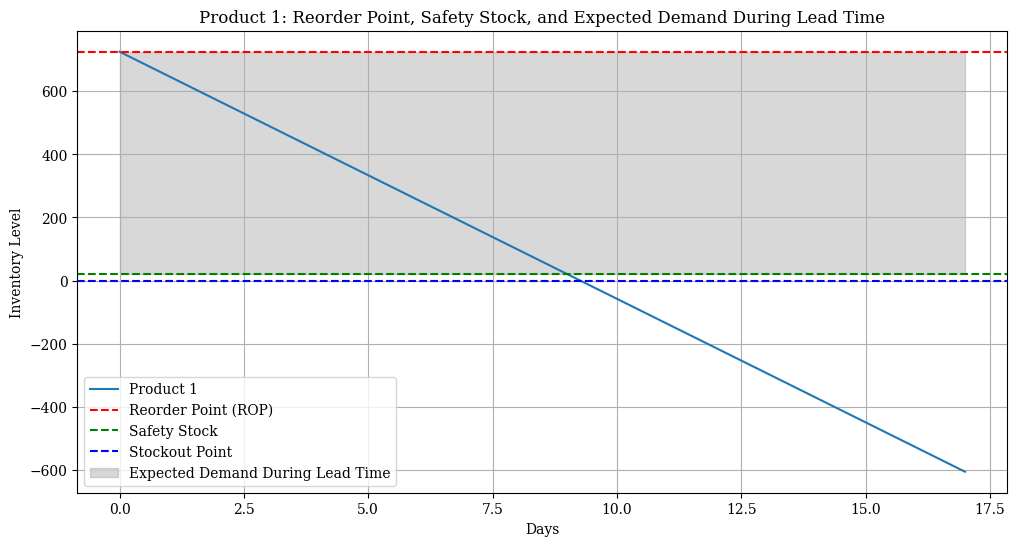

In [25]:
z_score = 1.65
lead_time = 9
std_dev_lead_time = 37.32
expected_demand_lead_time = 705

safety_stock = z_score * std_dev_lead_time / np.sqrt(lead_time)
reorder_point = safety_stock + expected_demand_lead_time

days = np.arange(0, 2 * lead_time, 1)
inventory_level = reorder_point - (days * (expected_demand_lead_time / lead_time))

plt.figure(figsize=(12, 6))
plt.plot(days, inventory_level, label='Product 1')
plt.axhline(y=reorder_point, color='r', linestyle='--', label='Reorder Point (ROP)')
plt.axhline(y=safety_stock, color='g', linestyle='--', label='Safety Stock')
plt.axhline(y=0, color='b', linestyle='--', label='Stockout Point')
plt.fill_between(days, safety_stock, reorder_point, color='gray', alpha=0.3, label='Expected Demand During Lead Time')

plt.title('Product 1: Reorder Point, Safety Stock, and Expected Demand During Lead Time')
plt.xlabel('Days')
plt.ylabel('Inventory Level')
plt.legend()
plt.grid(True)
plt.show()
